In [1]:
%cd ../..

C:\Users\Wight\PycharmProjects\ViCCT


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import os
import models.ViCCT_models  # Need to register the models!
from timm.models import create_model
from datasets.dataset_utils import img_equal_unsplit
import importlib
import time

In [3]:
model_name = 'ViCCT_base'  # Must be something like 'deit_small_distilled_patch16_224'.
model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\ViCCT base most public FT\\5-shot_1_percent\save_state_ep_1400_MAE_4.409.pth'
label_factor = 3000  # The label factor used to train this specific model.
dataset = 'Generic_ViCCT'  # Must be the exact name of the dataset
save_results = False  # When true, save the images, GTs and predictions. A folder for this is created automatically.
set_to_eval = 'test'  # val', 'test'. Which split to test the model on. 'train' does not work!

In [4]:
model = create_model(
        model_name,
        init_path=None,
        num_classes=1000,  # Not yet used anyway. Must match pretrained model!
        drop_rate=0.,
        drop_path_rate=0.,  
        drop_block_rate=None,
    )

model.cuda()

resume_state = torch.load(model_path)
model.load_state_dict(resume_state['net'])

model = model.eval()

In [5]:
dataloader = importlib.import_module(f'datasets.{dataset}.loading_data').loading_data
cfg_data = importlib.import_module(f'datasets.{dataset}.settings').cfg_data

train_loader, val_loader, test_loader, restore_transform = dataloader(model.crop_size)
if set_to_eval == 'val':
    my_dataloader = val_loader
elif set_to_eval == 'test':
    my_dataloader = test_loader
else:
    print(f'Error: invalid set --> {set_to_eval}')

Constructing the train split:
  Added dataset "ShanghaiTech_Part_B" with 320 images
320 train images found in 1 datasets.
No items added for val split.
Constructing the test split:
  Added dataset "Muni" with 18 images
18 test images found in 1 datasets.


In [6]:
save_path = None
if save_results:
    save_folder = 'DeiT' + '_' + dataset + '_' + set_to_eval + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_path = os.path.join('notebooks', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_path)

In [7]:
def plot_and_save_results(save_path, img, img_idx, gt, prediction, pred_cnt, gt_cnt):
    img_save_path = os.path.join(save_path, f'IMG_{img_idx}_AE_{abs(pred_cnt - gt_cnt):.3f}.jpg')
    
    plt.figure()
    f, axarr = plt.subplots(1, 3, figsize=(13, 13))
    axarr[0].imshow(img)
    axarr[1].imshow(gt, cmap=cm.jet)
    axarr[1].title.set_text(f'GT count: {gt_cnt:.3f}')
    axarr[2].imshow(prediction, cmap=cm.jet)
    axarr[2].title.set_text(f'predicted count: {pred_cnt:.3f}')
    plt.tight_layout()
    plt.savefig(img_save_path)
    plt.close('all')

In [8]:
def eval_model(model, my_dataloader, show_predictions, restore_transform, label_factor, cfg_data):
    loss_fn = torch.nn.MSELoss(reduction='none')
    
    AEs = []  # Absolute Errors
    SEs = []  # Squared Errors
    GTs = []
    preds = []
    
    crop_losses = []  # The loss of just the crops before recombining
    whole_img_losses = []  # The loss of the image after the crops are combined
    with torch.no_grad():


        for idx, (img, img_patches, gt_patches) in enumerate(my_dataloader):
            img_patches = img_patches.squeeze().cuda()
            gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
            img = img.squeeze()  # Remove batch dimension
            _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction
            
            img = restore_transform(img)

            pred_den = model(img_patches)  # Precicted density crops
            pred_den = pred_den.cpu()
            
            crop_loss = loss_fn(pred_den, gt_patches)
            crop_loss = crop_loss.mean((-2, -1))
            crop_losses.extend(crop_loss.tolist())

            # Restore GT and Prediction
            gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim
            
            whole_img_loss = loss_fn(den, gt)
            whole_img_loss = whole_img_loss.mean((-2, -1))  # Only has 2 dims though
            whole_img_losses.append(whole_img_loss.item())
            

            pred_cnt = den.sum() / label_factor
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            GTs.append(gt_cnt.item())
            preds.append(pred_cnt.item())
            relative_error = AEs[-1] / gt_cnt * 100
            print(f'IMG {idx:<3} '
                  f'Prediction: {pred_cnt:<9.3f} '
                  f'GT: {gt_cnt:<9.3f} '
                  f'Absolute Error: {AEs[-1]:<9.3f} '
                  f'Relative Error: {relative_error:.1f}%')
            
            if save_path:
                plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))
        Mean_crop_loss = np.mean(crop_losses)
        Mean_whole_img_loss = np.mean(whole_img_losses)

    return MAE, MSE, Mean_crop_loss, Mean_whole_img_loss, GTs, preds

In [9]:
MAE, MSE, Mean_crop_loss, Mean_whole_img_loss, GTs, preds = eval_model(model, my_dataloader, save_path, restore_transform, label_factor, cfg_data)
print(f'MAE/MSE: {MAE:.3f}/{MSE:.3f}, Mean crop loss: {Mean_crop_loss:.3f}, Mean whole image loss: {Mean_whole_img_loss:.3f}.')

IMG 0   Prediction: 34.046    GT: 42.000    Absolute Error: 7.954     Relative Error: 18.9%
IMG 1   Prediction: 140.865   GT: 132.930   Absolute Error: 7.935     Relative Error: 6.0%
IMG 2   Prediction: 149.875   GT: 150.000   Absolute Error: 0.125     Relative Error: 0.1%
IMG 3   Prediction: 17.915    GT: 18.000    Absolute Error: 0.085     Relative Error: 0.5%
IMG 4   Prediction: 6.265     GT: 3.000     Absolute Error: 3.265     Relative Error: 108.8%
IMG 5   Prediction: 32.091    GT: 34.000    Absolute Error: 1.909     Relative Error: 5.6%
IMG 6   Prediction: 8.054     GT: 7.000     Absolute Error: 1.054     Relative Error: 15.1%
IMG 7   Prediction: 218.620   GT: 220.964   Absolute Error: 2.344     Relative Error: 1.1%
IMG 8   Prediction: 67.062    GT: 79.964    Absolute Error: 12.902    Relative Error: 16.1%
IMG 9   Prediction: 52.534    GT: 50.000    Absolute Error: 2.534     Relative Error: 5.1%
IMG 10  Prediction: 12.039    GT: 9.000     Absolute Error: 3.039     Relative Error:

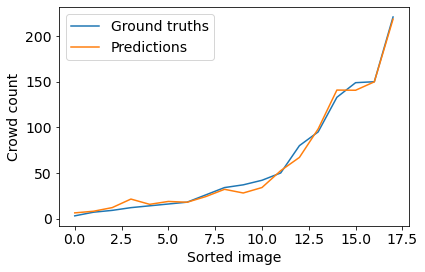

In [10]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

IMG 8, pred: 67.062, gt: 79.964. Error: -12.902


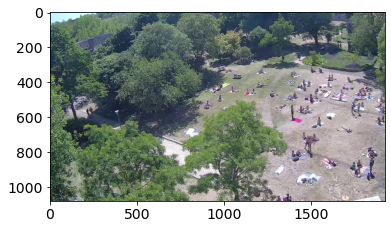

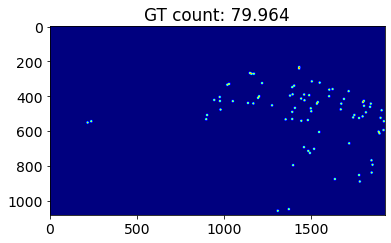

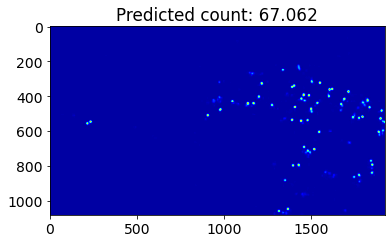

IMG 15, pred: 21.404, gt: 12.000. Error: 9.404


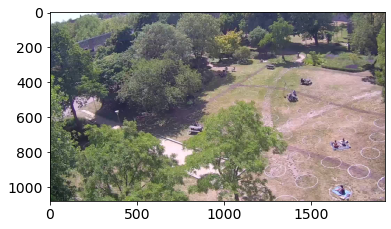

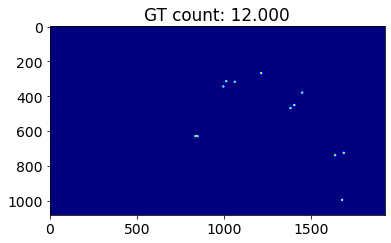

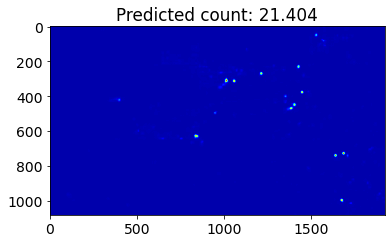

IMG 17, pred: 28.052, gt: 37.000. Error: -8.948


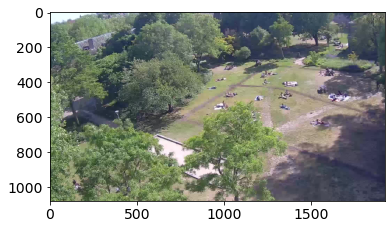

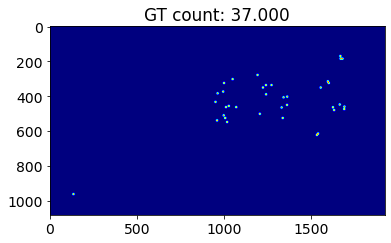

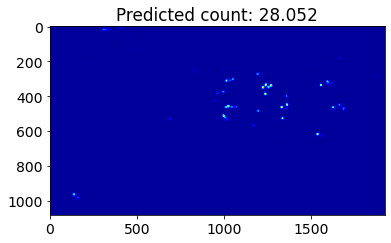

IMG 13, pred: 140.663, gt: 148.964. Error: -8.301


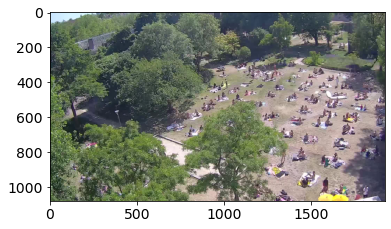

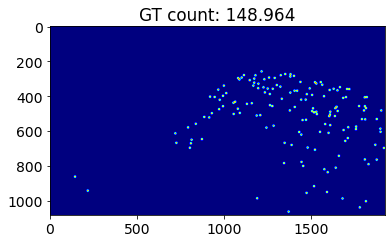

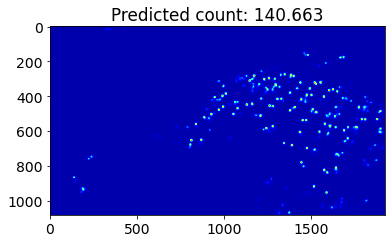

IMG 0, pred: 34.046, gt: 42.000. Error: -7.954


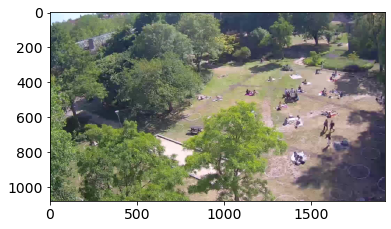

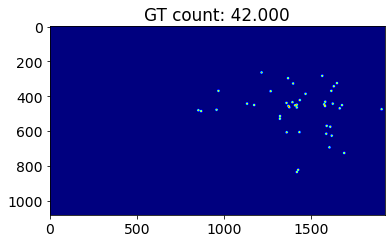

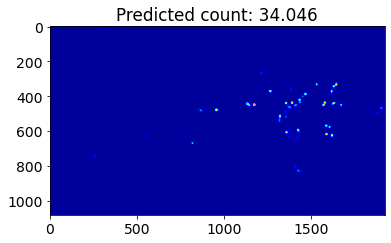

IMG 1, pred: 140.865, gt: 132.930. Error: 7.935


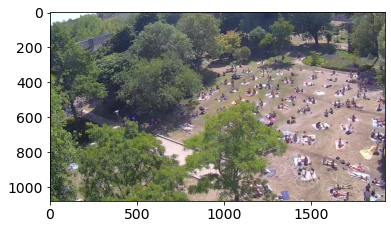

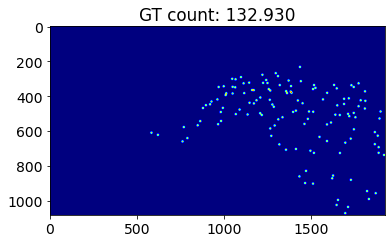

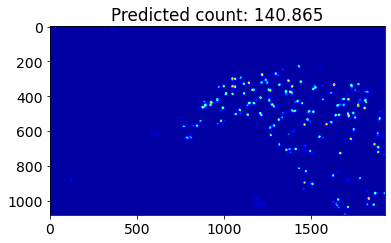

IMG 4, pred: 6.265, gt: 3.000. Error: 3.265


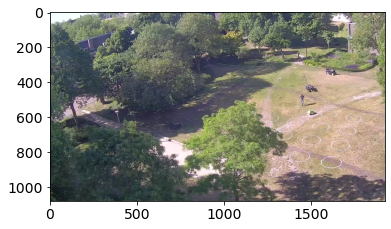

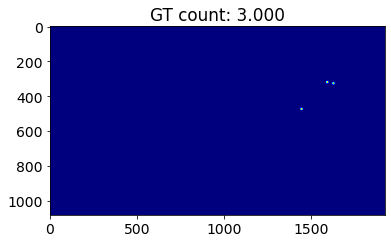

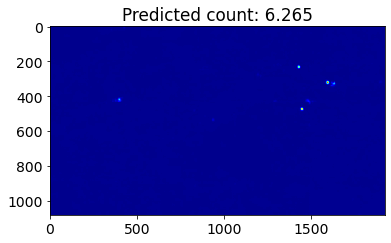

IMG 16, pred: 98.250, gt: 95.000. Error: 3.250


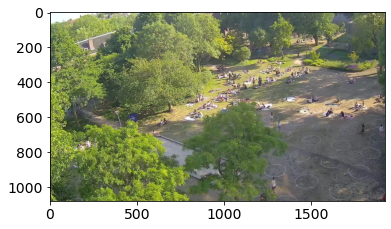

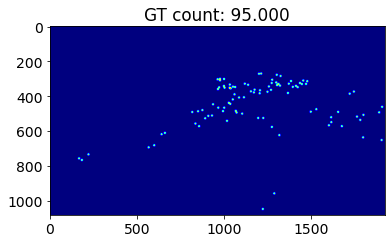

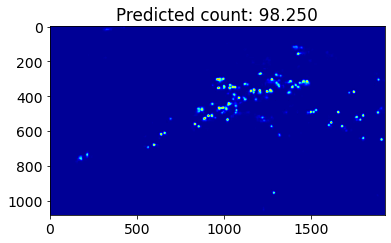

IMG 10, pred: 12.039, gt: 9.000. Error: 3.039


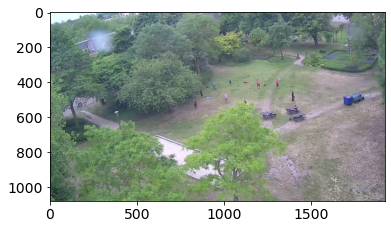

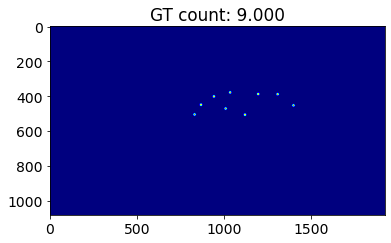

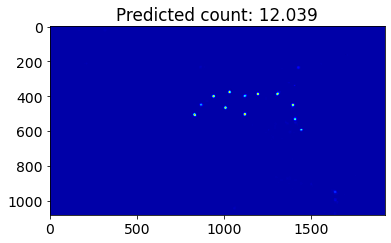

IMG 14, pred: 18.796, gt: 16.000. Error: 2.796


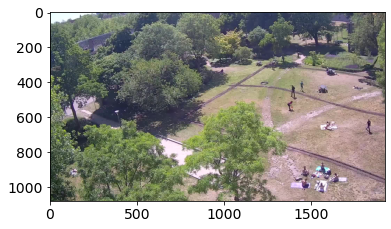

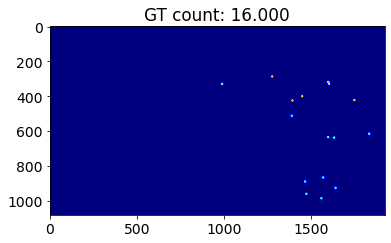

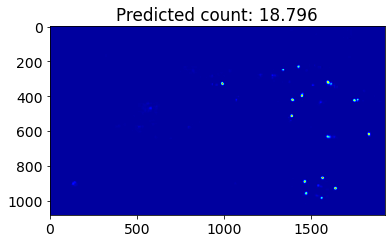

In [11]:
sorted_error_idxs = np.flip(np.argsort(np.abs(GTs - preds)))

with torch.no_grad():
    for idx in sorted_error_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        plt.figure()
        plt.imshow(gt.numpy(), cmap=cm.jet)
        plt.title(f'GT count: {gt_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()

IMG 3, pred: 17.915, gt: 18.000. Error: -0.085


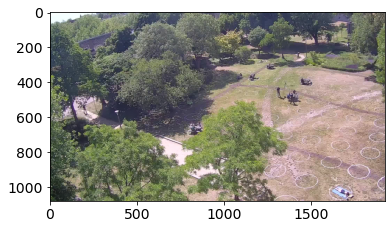

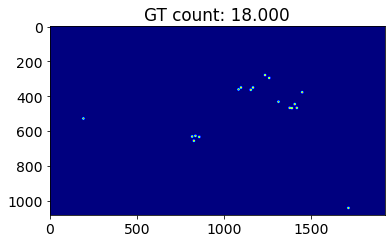

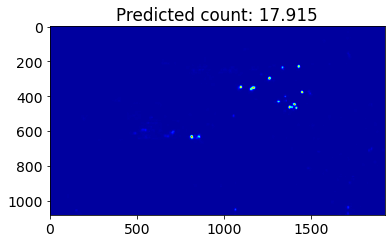

IMG 2, pred: 149.875, gt: 150.000. Error: -0.125


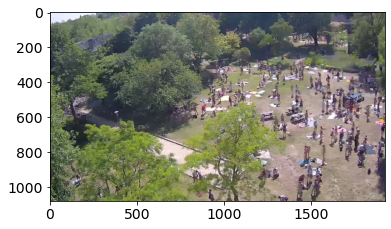

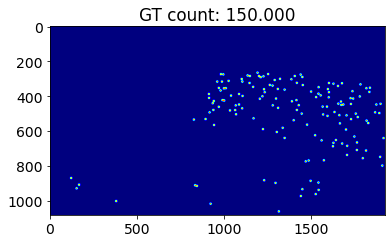

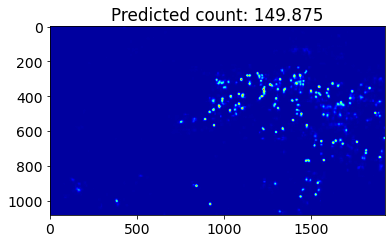

IMG 6, pred: 8.054, gt: 7.000. Error: 1.054


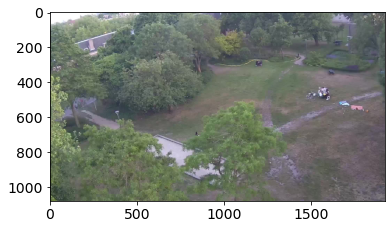

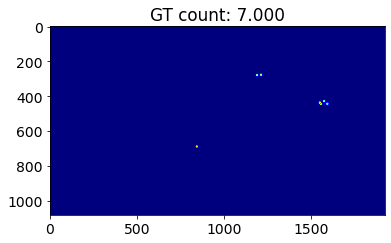

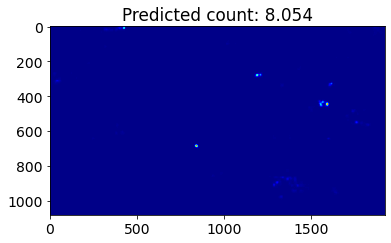

IMG 12, pred: 15.633, gt: 14.000. Error: 1.633


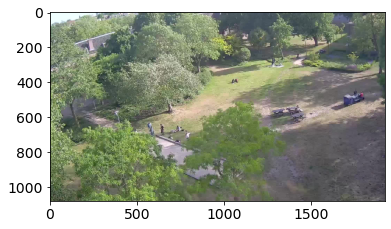

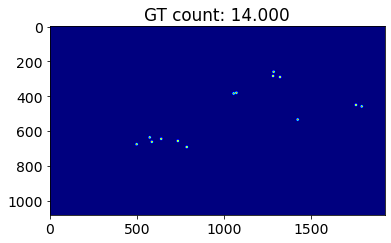

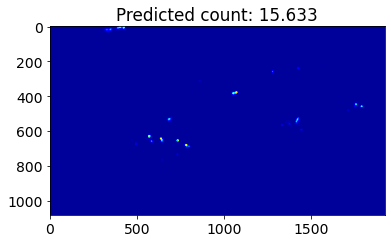

IMG 11, pred: 24.122, gt: 26.000. Error: -1.878


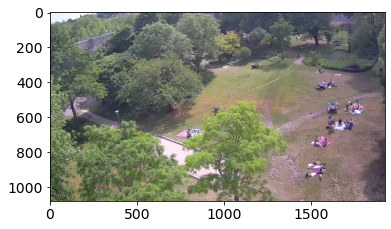

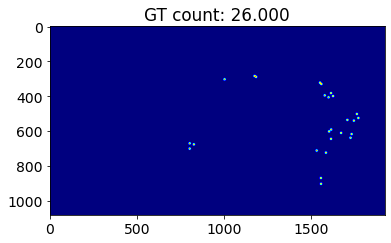

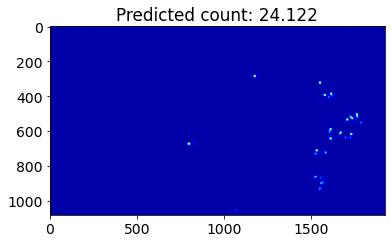

IMG 5, pred: 32.091, gt: 34.000. Error: -1.909


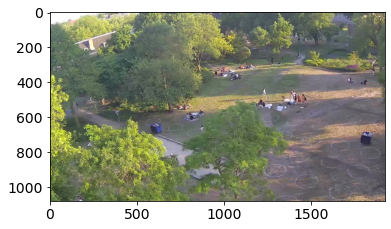

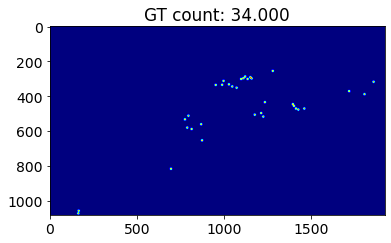

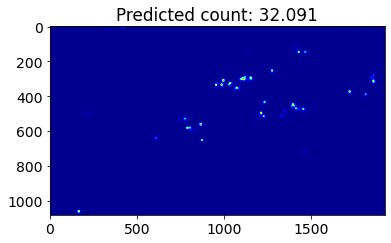

IMG 7, pred: 218.620, gt: 220.964. Error: -2.344


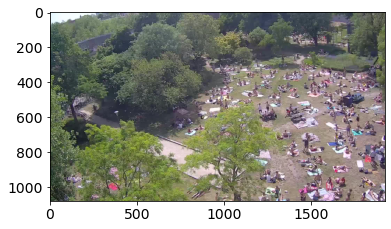

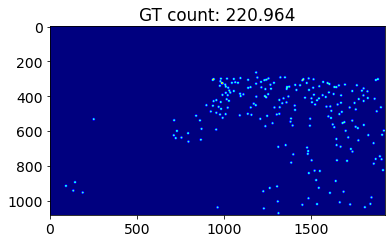

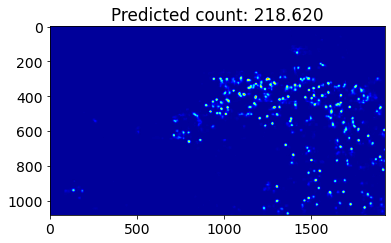

IMG 9, pred: 52.534, gt: 50.000. Error: 2.534


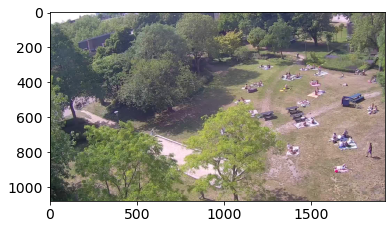

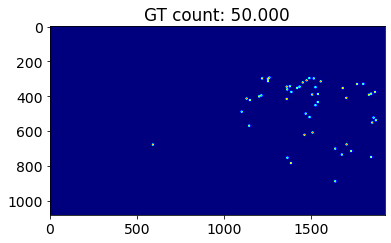

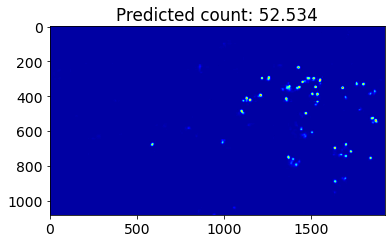

IMG 14, pred: 18.796, gt: 16.000. Error: 2.796


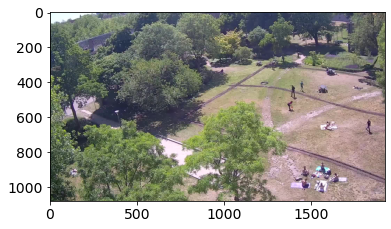

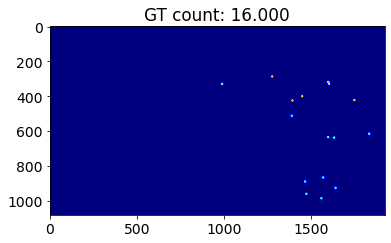

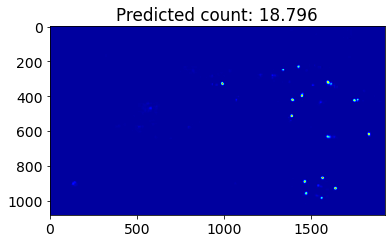

IMG 10, pred: 12.039, gt: 9.000. Error: 3.039


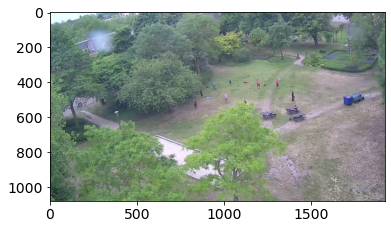

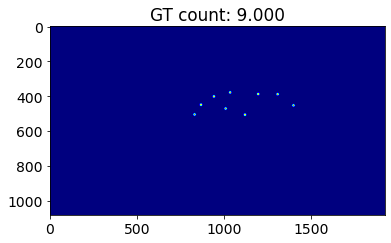

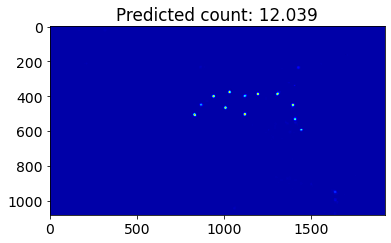

In [12]:
sorted_good_idxs = np.argsort(np.abs(GTs - preds))

with torch.no_grad():
    for idx in sorted_good_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        plt.figure()
        plt.imshow(gt.numpy(), cmap=cm.jet)
        plt.title(f'GT count: {gt_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()